# Image Classification and Regression

## Generative functions

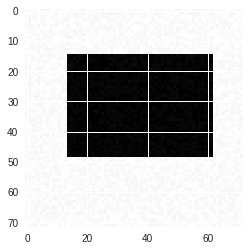

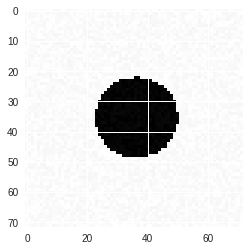

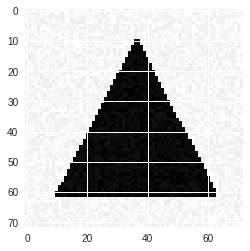

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


## Simple Classification

In [70]:
from keras.utils import np_utils
X_train, Y_train = generate_dataset_classification(300, 20)
Y_train = np_utils.to_categorical(Y_train, 3)
X_test, Y_test = generate_dataset_classification(200, 20)
Y_test = np_utils.to_categorical(Y_test, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


#### Importations

In [0]:
import keras
import PIL
import h5py
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt

#### Stochastic Gradient Descent 

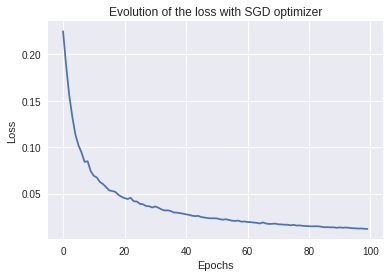

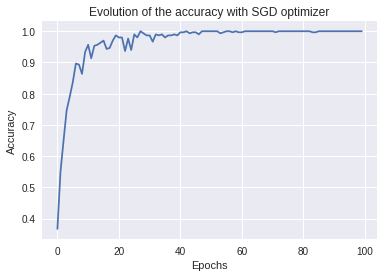

In [85]:
model = Sequential()
model.add(Dense(3, activation = 'softmax', input_shape = (72*72,)))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9,nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of the loss with SGD optimizer')
plt.figure()
plt.plot(history.history['acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracy with SGD optimizer')
plt.show()

In [88]:
print("Test accuracy: %f" % model.evaluate(X_test, Y_test, verbose=0)[1])

Test accuracy: 1.000000


#### Adam Optimizer

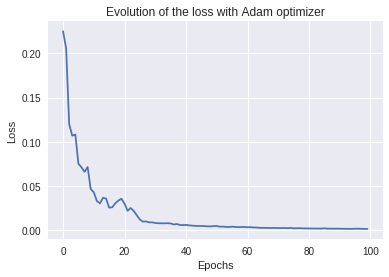

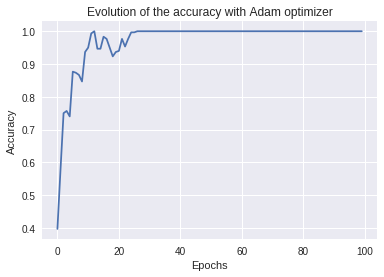

In [110]:
model = Sequential()
model.add(Dense(3, activation = 'softmax', input_shape = (72*72,)))
adam = Adam(lr=0.0005)
model.compile(loss='mean_squared_error', optimizer=adam, metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of the loss with Adam optimizer')
plt.figure()
plt.plot(history.history['acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracy with Adam optimizer')
plt.show()

In [111]:
print("Test accuracy: %f" % model.evaluate(X_test, Y_test, verbose=0)[1])

Test accuracy: 1.000000


For both models all images of the test set are correctly classified but Adam optimizer converges to a zero loss faster than SGD. 

---



## Visualisation of the solution

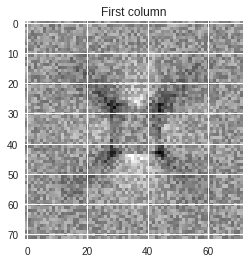

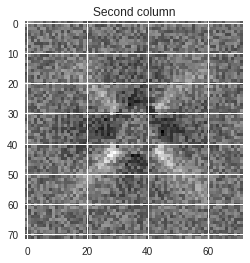

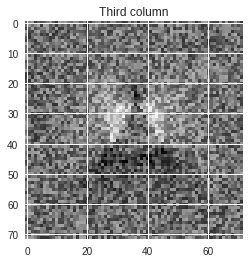

In [113]:
weights = model.get_weights()[0]
a = weights[:,0].reshape((72,72))
b = weights[:,1].reshape((72,72))
c = weights[:,2].reshape((72,72))
plt.imshow(a, 'gray')
plt.title('First column')
plt.show()
plt.imshow(b, 'gray')
plt.title('Second column')
plt.show()
plt.imshow(c, 'gray')
plt.title('Third column')
plt.show()

We can see that each column seems dedicated to the detection of a specific class. The first one to squares, the second to circles and the last one to triangles.

## A More Difficult Classification Problem

#### Creating datasets

In [126]:
X_train, Y_train = generate_dataset_classification(500, 20, True)
X_test, Y_test = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [0]:
Y_train = np_utils.to_categorical(Y_train,3)

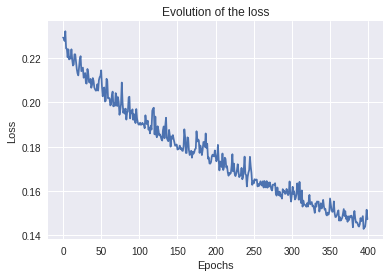

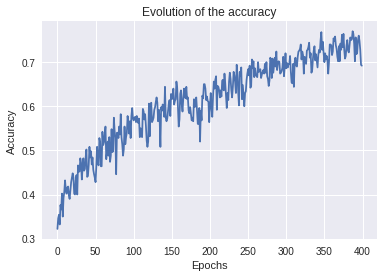

In [128]:
model = Sequential()
model.add(Dense(3, activation = 'softmax', input_shape = (72*72,)))
adam = Adam(0.0001)
model.compile(loss='mean_squared_error', optimizer=adam, metrics = ['accuracy'])
history = model.fit(X_train, Y_t, epochs=400, batch_size=32, verbose=0)
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of the loss')
plt.figure()
plt.plot(history.history['acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracy')
plt.show()

In [129]:
print("Test accuracy: %f" % model.evaluate(X_test, Y_test, verbose=0)[1])

Test accuracy: 0.420000


We can see that the accuracy on the test set is way lower than in the train set. The model is overfitting and it is not satisfactory to have an accuracy of 0.42.

#### Convolutional Neural Network

In [0]:
X_train = X_train.reshape((500, IMAGE_SIZE, IMAGE_SIZE, 1))

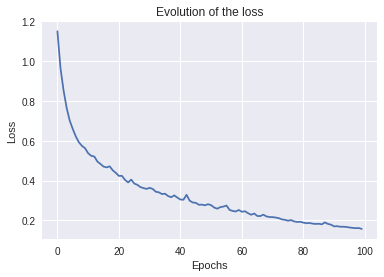

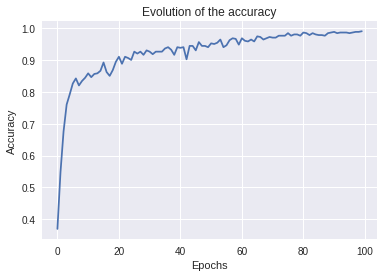

In [132]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
model = Sequential()
model.add(Conv2D(16, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
adam = Adam(0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of the loss')
plt.figure()
plt.plot(history.history['acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracy')
plt.show()

In [135]:
X_test = X_test.reshape((X_test.shape[0], IMAGE_SIZE,IMAGE_SIZE,1))
print("Test accuracy: %f" % model.evaluate(X_test, Y_test, verbose=0)[1])

Test accuracy: 0.810000


With this model we are still doing a bit of overfitting because the training accuracy is higher than the test accuracy but it is better than the previous model because the accuracy is 0.81. Plus, there is less variance in the loss, at almost every step it decreases contrary as in the linear model.

## A Regression Problem

#### Datasets generation

In [137]:
[X_train, Y_train] = generate_dataset_regression(2000, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220


#### Vertices Normalisation

In [0]:
def sort_abscissa(Y_train):
  """
    This function sorts the points of Y_train. Vertices are sorted by their abscissa.
  """
  x_vertices = np.array([Y_train[:,0], Y_train[:,2],Y_train[:,4]])
  i = np.argmax(x_vertices, axis=0)
  j = np.argmin(x_vertices, axis=0)
  k = 3 - i - j
  
  return np.array([np.diag(Y_train[:,2*i]), np.diag(Y_train[:,2*i+1]), np.diag(Y_train[:,2*k]), np.diag(Y_train[:,2*k+1]),
                   np.diag(Y_train[:,2*j]), np.diag(Y_train[:,2*j+1])]).T

In [0]:
Y_train = sort_abscissa(Y_train)
Y_test = sort_abscissa(Y_test)
X_train = X_train.reshape((2000,IMAGE_SIZE,IMAGE_SIZE,1))

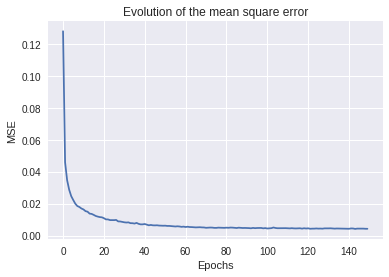

In [145]:
from keras.layers import Dropout
model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (5,5), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6))
adam = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)
history = model.fit(X_train, Y_train, epochs=150, batch_size=32, verbose=0)
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Evolution of the mean square error')
plt.show()

In [147]:
X_test = X_test.reshape((300,IMAGE_SIZE,IMAGE_SIZE,1))
print("Test Loss: %f" % model.evaluate(X_test, Y_test, verbose=0))

Test Loss: 0.004095


#### Visualize 50 first predictions

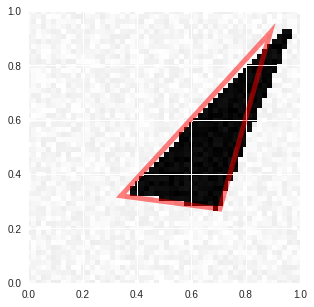

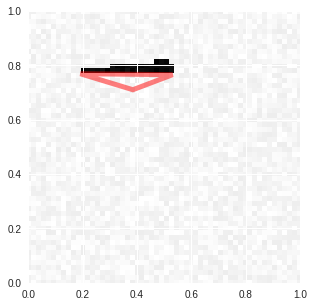

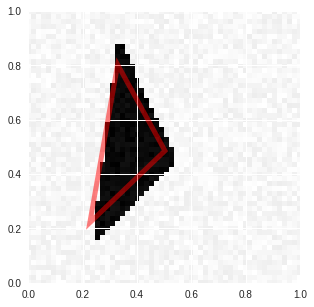

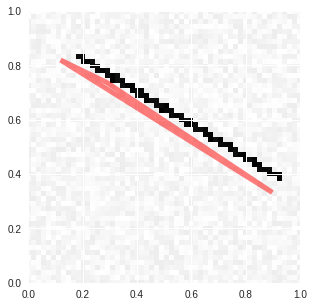

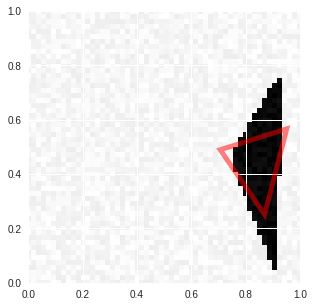

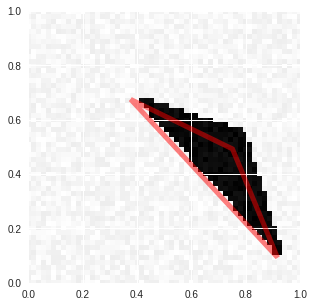

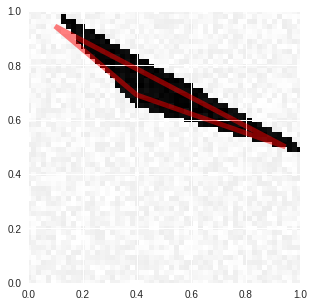

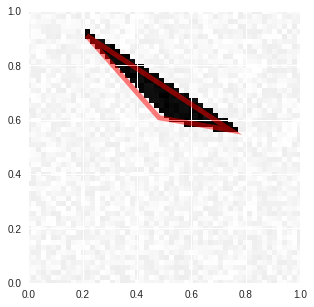

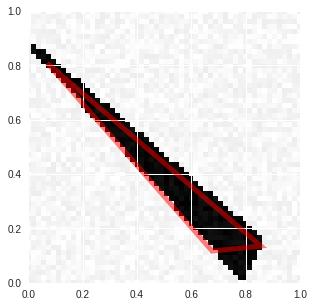

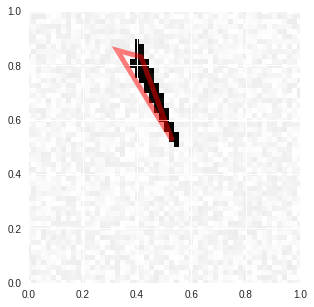

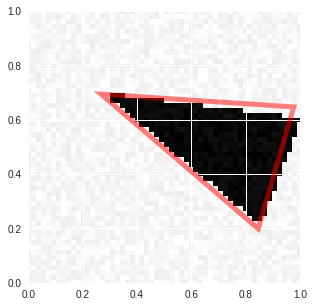

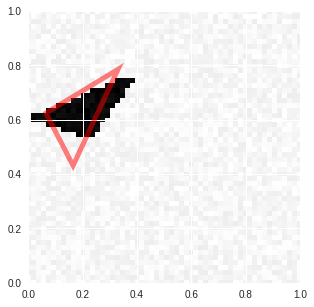

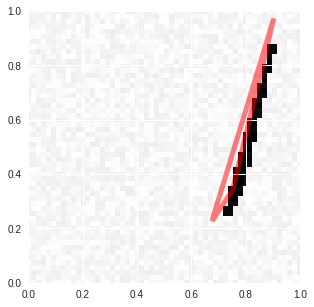

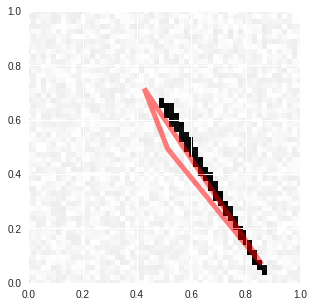

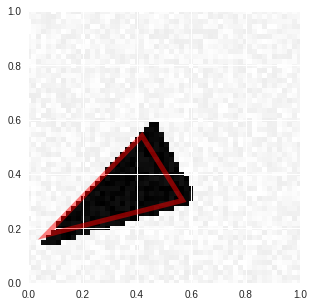

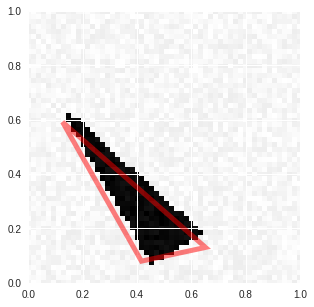

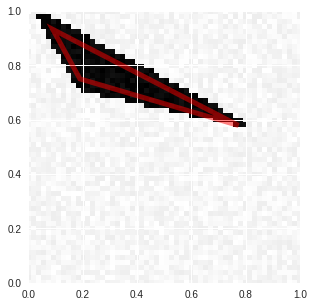

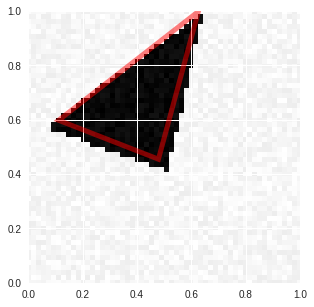

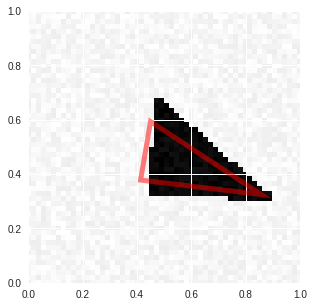

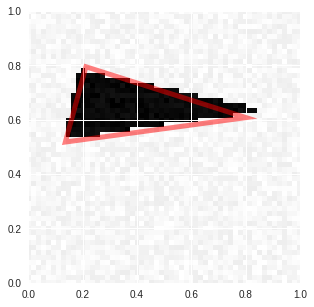

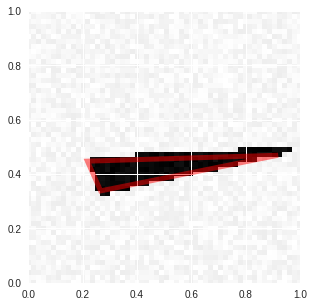

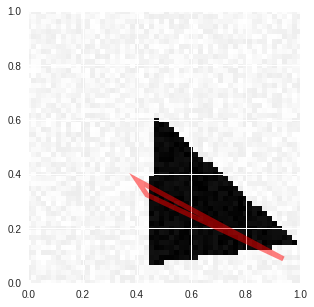

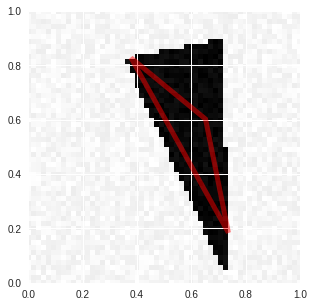

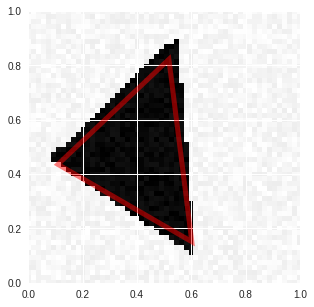

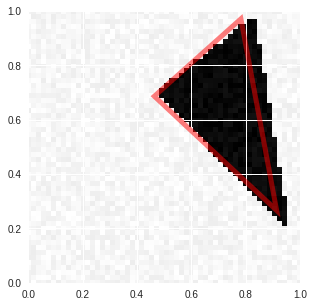

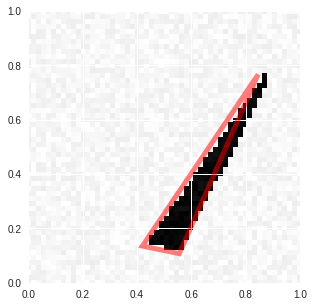

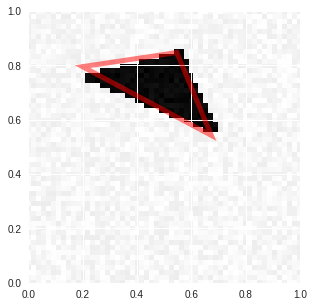

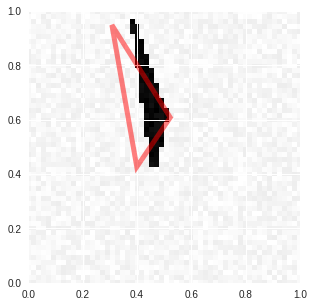

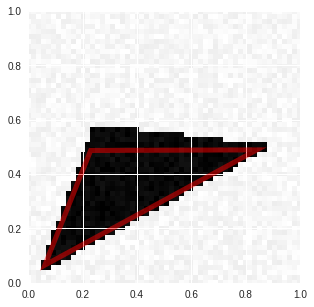

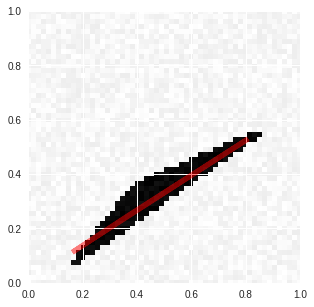

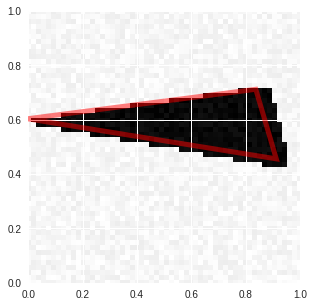

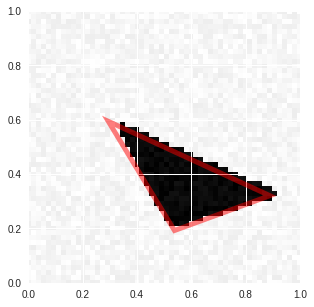

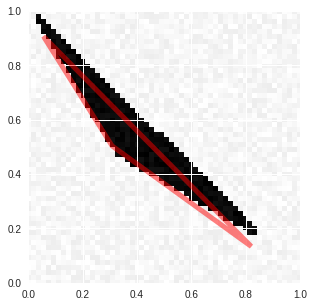

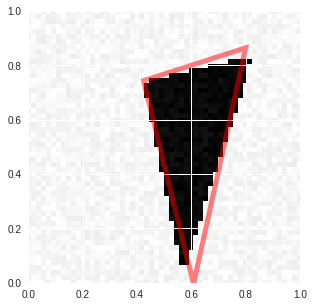

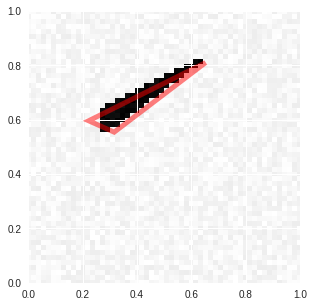

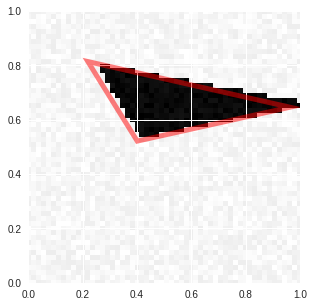

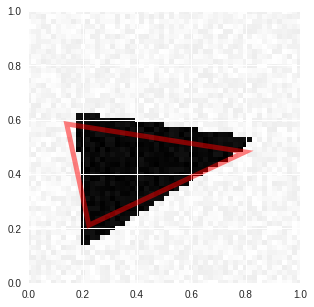

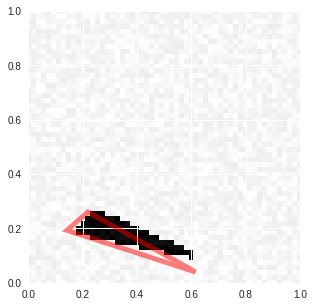

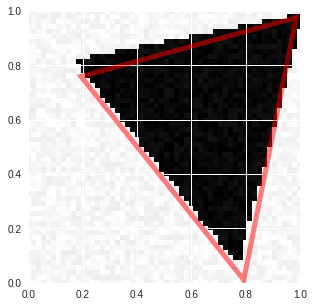

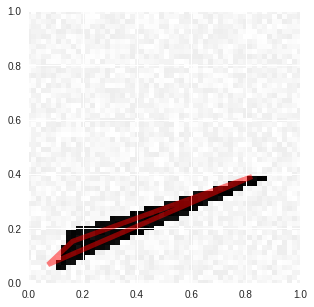

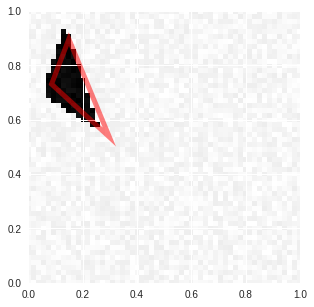

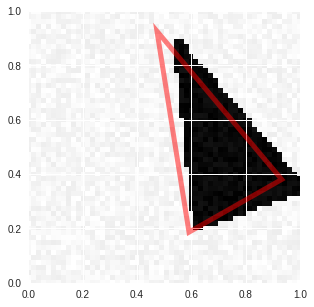

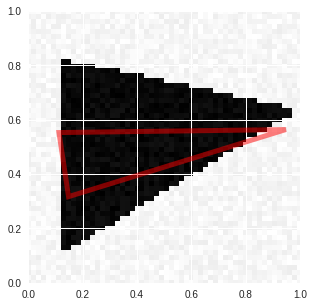

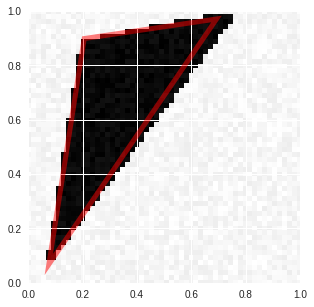

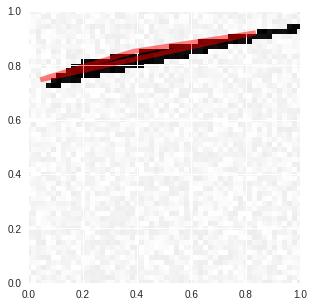

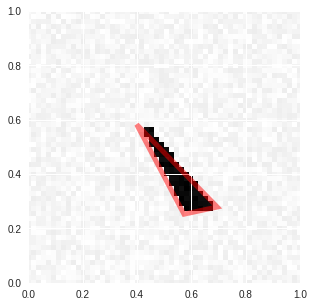

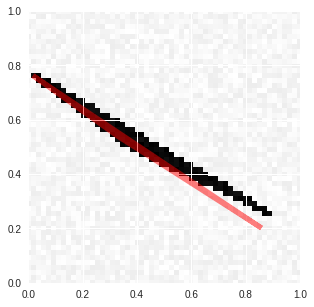

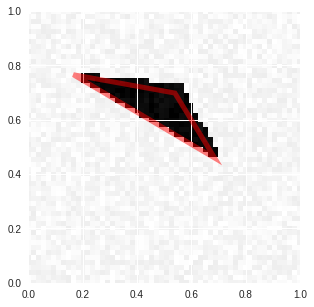

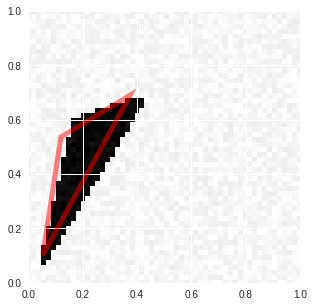

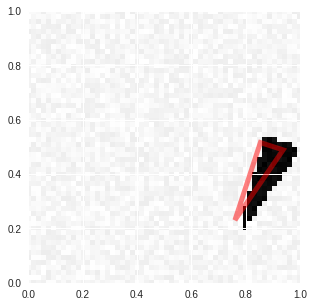

In [148]:
pred = model.predict(X_test)
for i in range (50):
    visualize_prediction(X_test[i], pred[i])

By looking at the results, we can see that triangles are well located even if it is not perfect.

## Image Denoising
#### Generative functions

In [0]:
def generate_two_rectangles(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return (generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.0))

def generate_two_disks(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return (generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0))
  
def generate_two_triangles(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return (imdata, generate_a_drawing(figsize, U, V, 0.))
            
def generate_dataset_denoising(nb_samples, noise=[10,20,25,30,50], free_location=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros((nb_samples, im_size))
    print('Creating data:')
    for i in range(nb_samples):
        noise_choice = np.random.choice(noise)
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_two_rectangles(noise_choice, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_two_disks(noise_choice, free_location)
        else:
            X[i], Y[i] = generate_two_triangles(noise_choice, free_location)
        X[i] = (X[i] + noise_choice) / (255 + 2 * noise_choice)
    return [X, Y]

In [159]:
X_train, Y_train = generate_dataset_denoising(2000, 20)
X_test, Y_test = generate_dataset_denoising(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220


In [0]:
X_train = X_train.reshape((2000, 72,72,1))
Y_train = Y_train.reshape((2000, 72,72,1))
X_test = X_test.reshape((300, 72,72,1))
Y_test = Y_test.reshape((300, 72,72,1))

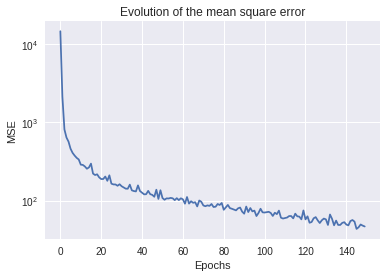

In [161]:
from keras.layers import UpSampling2D
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1, (3,3), activation='relu', padding='same'))

adam = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)
history = model.fit(X_train, Y_train, epochs=150, batch_size=32, verbose=0)
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.title('Evolution of the mean square error')
plt.show()

In [162]:
print("Test Loss: %f" % model.evaluate(X_test, Y_test, verbose=0))

Test Loss: 62.951058


#### Visualize 50 first predictions

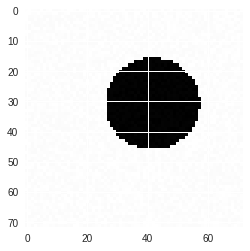

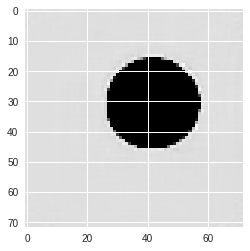

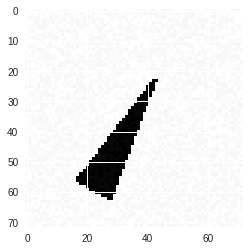

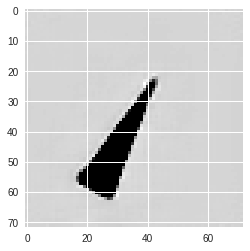

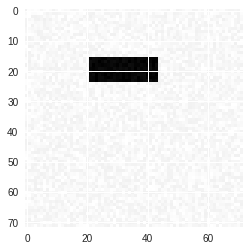

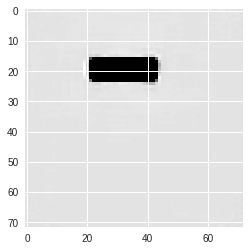

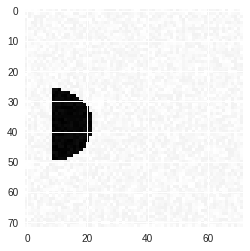

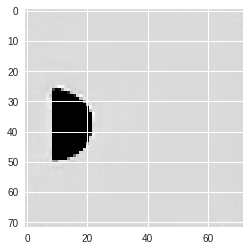

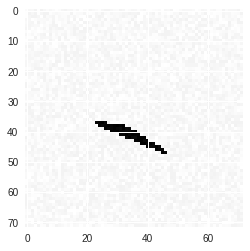

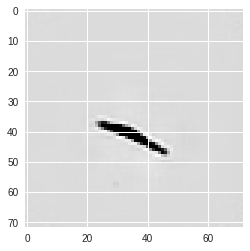

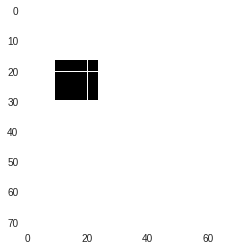

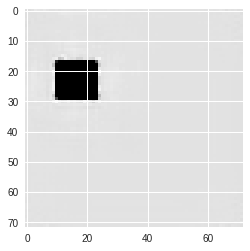

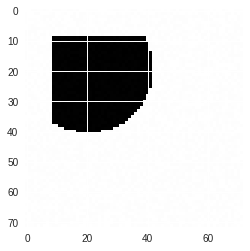

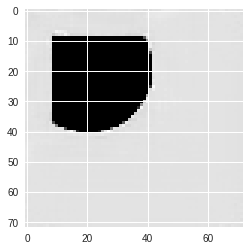

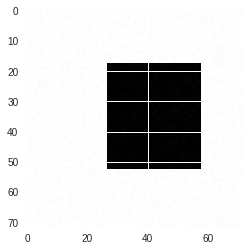

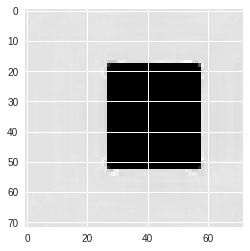

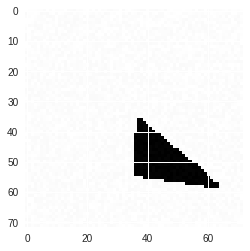

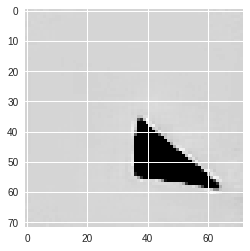

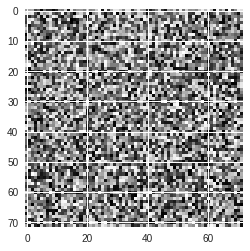

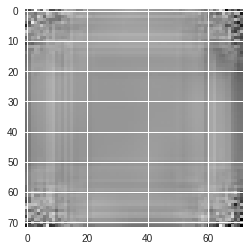

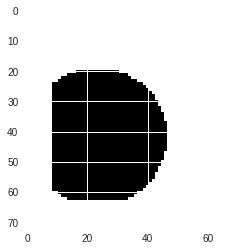

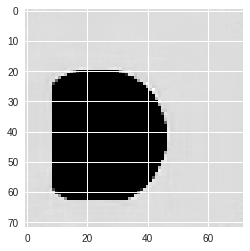

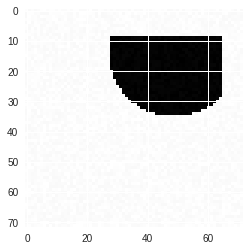

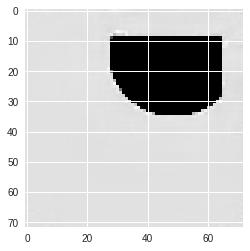

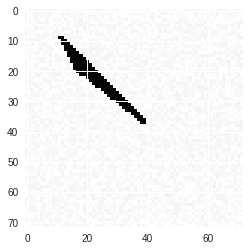

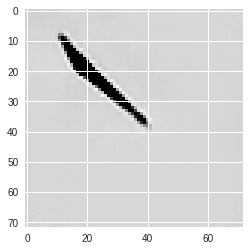

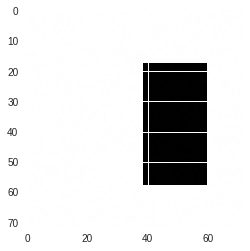

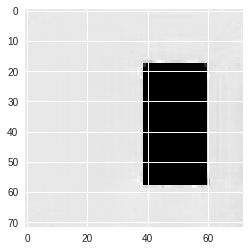

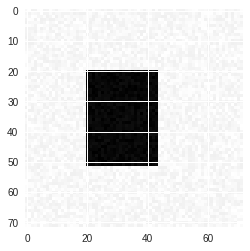

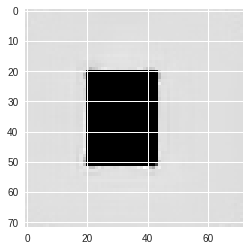

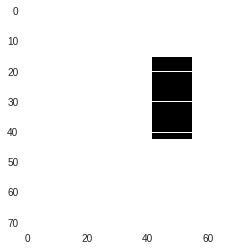

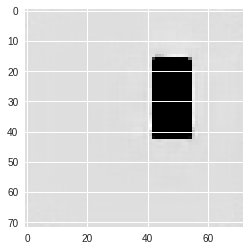

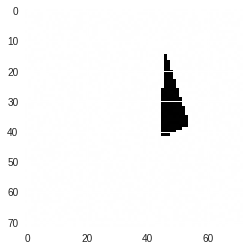

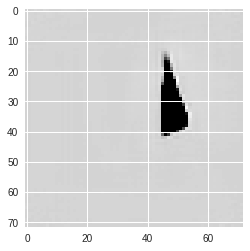

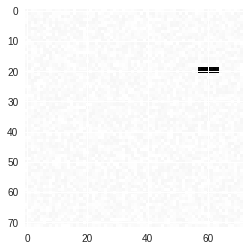

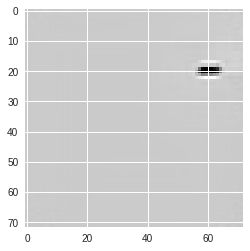

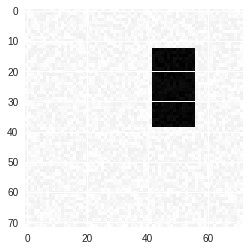

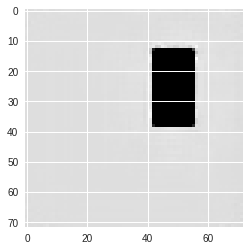

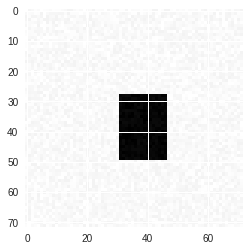

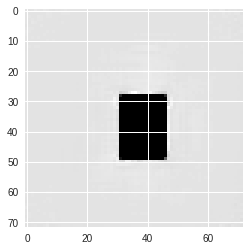

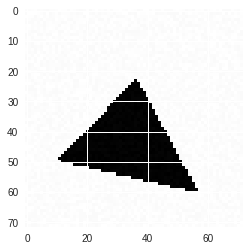

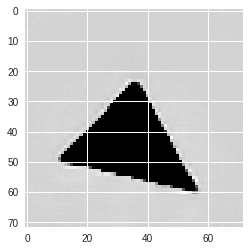

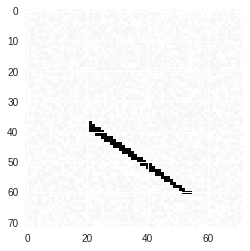

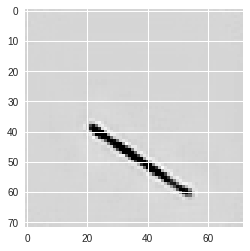

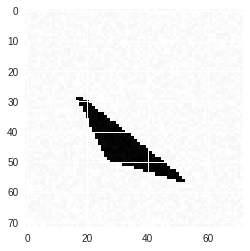

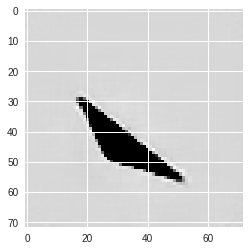

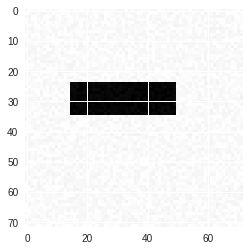

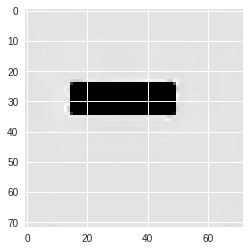

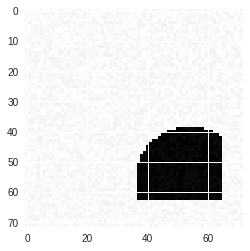

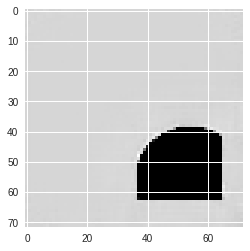

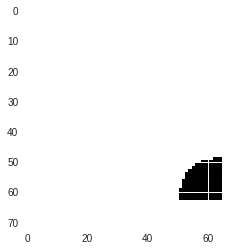

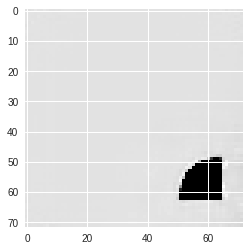

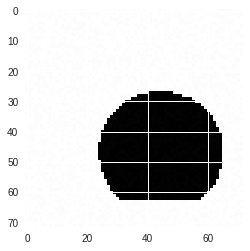

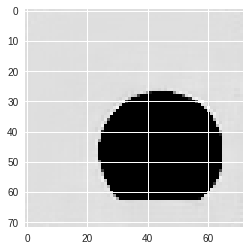

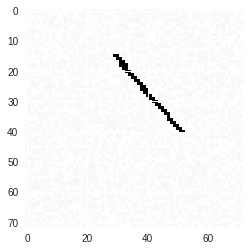

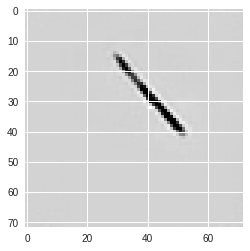

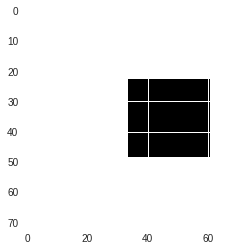

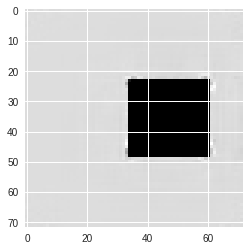

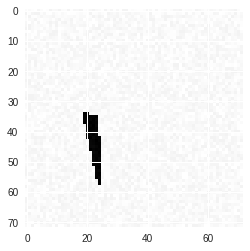

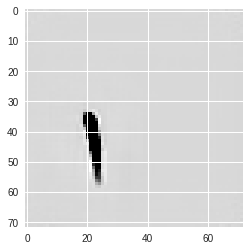

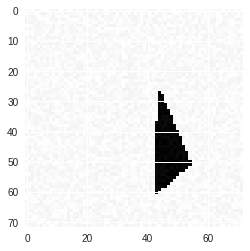

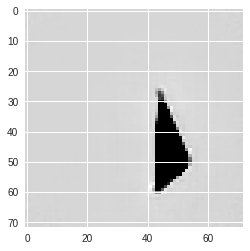

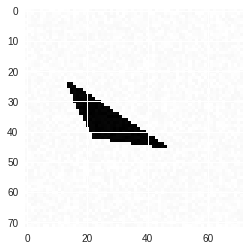

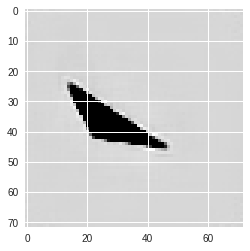

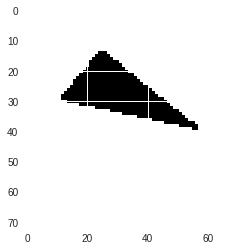

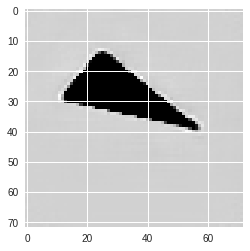

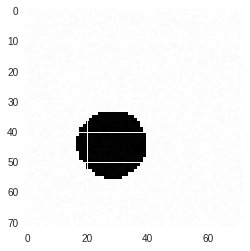

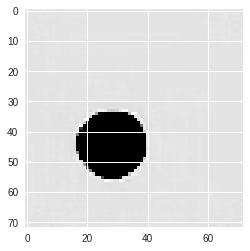

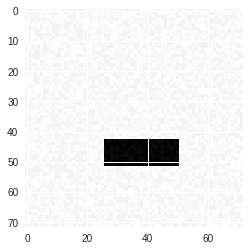

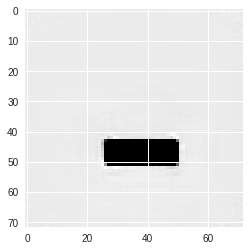

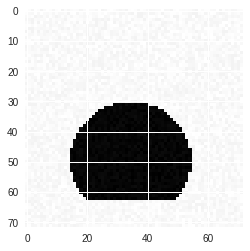

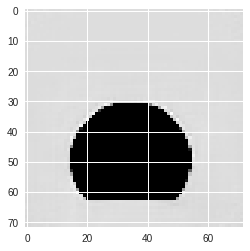

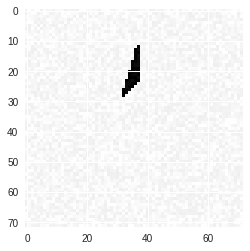

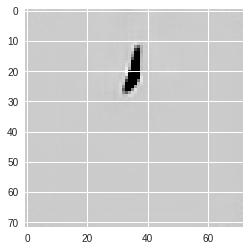

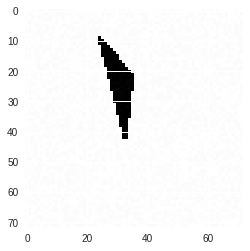

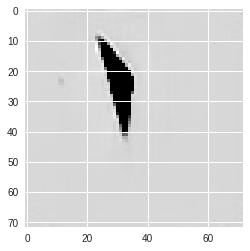

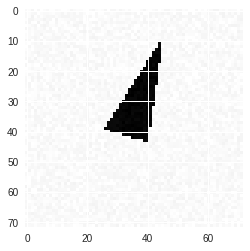

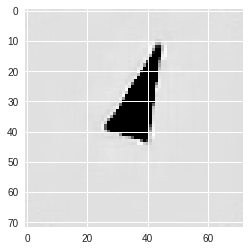

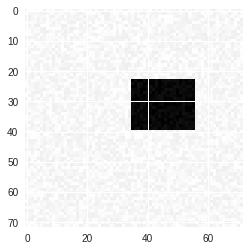

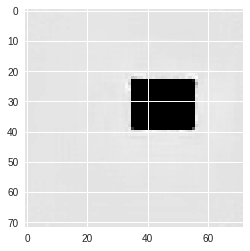

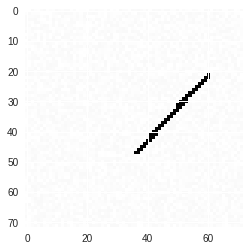

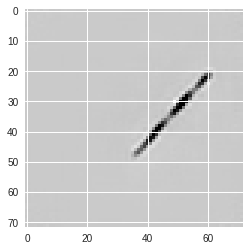

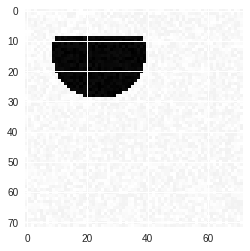

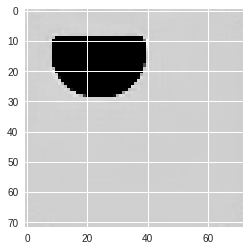

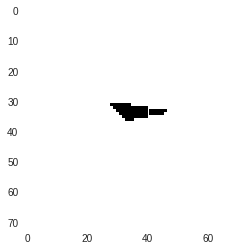

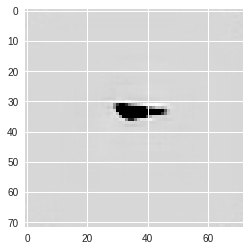

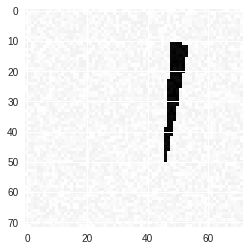

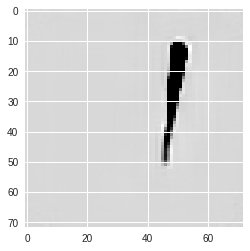

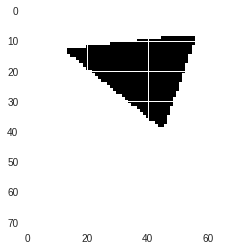

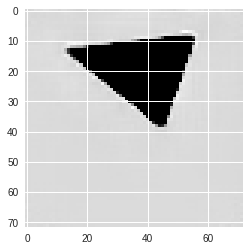

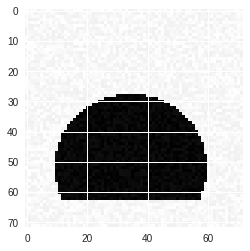

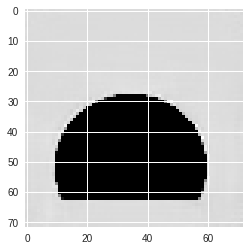

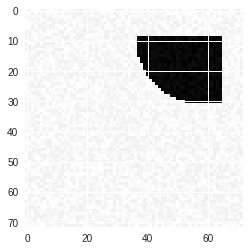

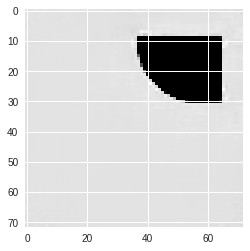

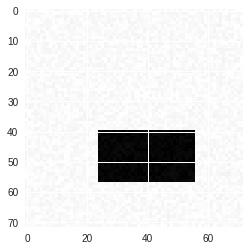

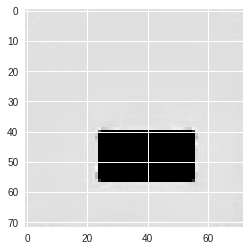

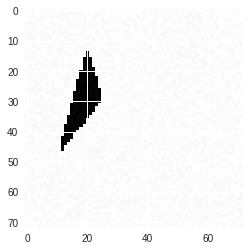

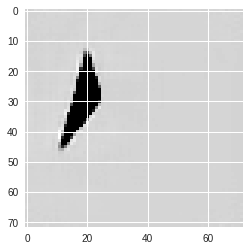

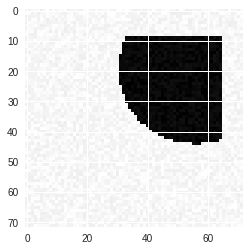

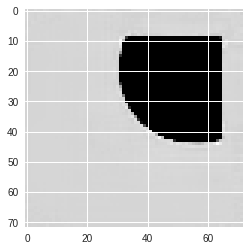

In [163]:
pred = model.predict(X_test)
for i in range(50):
  plt.imshow(X_test[i].reshape((72,72)), cmap='gray')
  plt.show()
  plt.imshow(pred[i].reshape((72,72)), cmap='gray')
  plt.show()

The hourglass network works well in area that should be constant but at corners there is some ringing.